In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12


# import seaborn as sns

# from imblearn.over_sampling import SMOTE

In [120]:
df = pd.read_csv("/Users/ianchang/0.Workspaces/slaCoefficientProject/Origination Data/DTT SLA Summary - Overall Summary.csv").drop(columns=["Unnamed: 0", "partner_id", "partner", "xfr_request_id", "request_id", "true_SLA", "runtime_per_day", "payment_code"])

In [123]:
df['submit_date'] = pd.to_datetime(df['submit_date'])
df["submit_date"] = df["submit_date"].dt.floor('D')

# Extract year and month, then create the submit_month column
df['submit_month'] = df['submit_date'].dt.to_period('M')

In [124]:
origination_by_month = df[["on_time", "submit_month"]].groupby(by="submit_month").mean().reset_index()


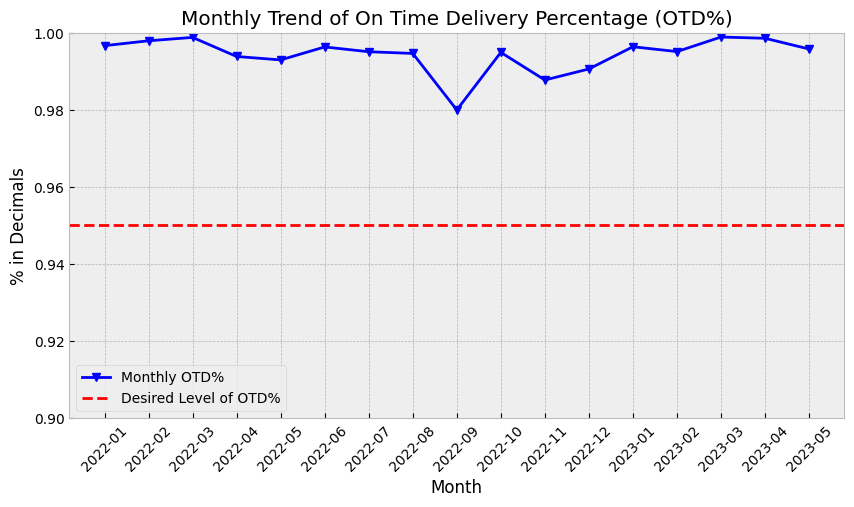

In [125]:
fig, ax = plt.subplots(figsize = (10,5))
plt.style.use('bmh')

ax.plot(origination_by_month["submit_month"].astype("str"), origination_by_month["on_time"], marker="v", label="Monthly OTD%", color="blue")


ax.set_ylim(0.9, 1)
ax.axhline(y=0.95, color='red', linestyle='--', label="Desired Level of OTD%")
ax.set_title("Monthly Trend of On Time Delivery Percentage (OTD%)")
ax.set_xlabel("Month")
ax.set_ylabel("% in Decimals")

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [126]:
import random
import string

def get_random_string(length=8):
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(length))

df['author'] = df['author'].str.replace(r'@.*', '', regex=True)

unique_authors = df['author'].unique()

author_mapping = {}

for author in unique_authors:
    author_mapping[author] = get_random_string()

df['author_anonymous'] = df['author'].map(author_mapping)



In [129]:
df_orig = df[['author_anonymous', 'package_id', 'asset_type',
       'content_category', 'reason_code', 'original_audio_language',
       'source_language', 'target_language', 'runtime_minutes',
        'start_date', 'submit_date', 'due_date', 'on_time']]

In [127]:
# df = df.sort_values(by="author_anonymous")

In [128]:
# df.groupby(by=["author_anonymous", "asset_type", "reason_code", "source_language", "target_language"]).agg({"runtime_minutes": "sum"}).head(50)

## Service Level Agreement Based on Asset Types:

● Standard SLA for all subtitles and language templates: 15 RTM per Day

● Rush SLA for all subtitles and language templates: 30 RTM Day

● Standard SLA for CC for Original Audio language: 30 RTM per Day

● Rush SLA for CC for Original Audio language: 60 RTM per Day

● Standard SLA for CC for Non Original Audio language: 15 RTM per Day

● Rush SLA for CC for Non Original Audio language: 30 RTM per Day

In [130]:
# Initialize  
df["expected_daily_output"] = 0

for index, row in df.iterrows():
    if row["asset_type"] == "SUBTITLE":
        if row["reason_code"] == "STANDARD":
            df.at[index, "expected_daily_output"] = 15
        elif row["reason_code"] == "RUSH":
            df.at[index, "expected_daily_output"] = 30

    elif row["asset_type"] == "CLOSED_CAPTIONING":
        if row["original_audio_language"] == row["target_language"]:
            if row["reason_code"] == "STANDARD":
                df.at[index, "expected_daily_output"] = 30
            elif row["reason_code"] == "RUSH":
                df.at[index, "expected_daily_output"] = 60
        else:
            if row["reason_code"] == "STANDARD":
                df.at[index, "expected_daily_output"] = 15
            elif row["reason_code"] == "RUSH":
                df.at[index, "expected_daily_output"] = 30
    
    elif row["asset_type"] == "LANGUAGE_TEMPLATE":
        if row["reason_code"] == "STANDARD":
            df.at[index, "expected_daily_output"] = 15
        elif row["reason_code"] == "RUSH":
            df.at[index, "expected_daily_output"] = 30

df = df[['author_anonymous', 'package_id', 'asset_type',
       'content_category', 'reason_code', 'original_audio_language',
       'source_language', 'target_language',"expected_daily_output", 'runtime_minutes',
        'start_date', 'submit_date', 'due_date', 'on_time',]]

In [131]:
import pandas as pd

def calculate_business_days(start_date_str, end_date_str):
    """
    Calculate the number of business days between two dates excluding weekends.

    Parameters:
    start_date_str (str): The start date in YYYY-MM-DD format.
    end_date_str (str): The end date in YYYY-MM-DD format.

    Returns:
    int: The number of business days between the two dates.
    """
    
    # Convert the date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    
    # Calculate the number of business days (excluding weekends)
    business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # Return the count of business days
    return len(business_days)


In [133]:
import math

for index, row in df.iterrows():
    df.at[index,"num_days_spent"] = calculate_business_days(row["start_date"], row["submit_date"])

for index, row in df.iterrows():
    df.at[index, "expected_TAT"] = np.ceil(row["runtime_minutes"] / row["expected_daily_output"])

for index, row in df.iterrows():    
    df.at[index, "sla_coef"] = row["num_days_spent"] / row["expected_TAT"]
    if row["num_days_spent"] <= row["expected_TAT"]:
        df.at[index, "on_time_actual"] = 1
    else:
        df.at[index, "on_time_actual"] = 0

df = df.rename(columns={"on_time": "on_time_current"})

df = df[['author_anonymous', 'package_id', 'asset_type',
       'content_category', 'reason_code', 'original_audio_language',
       'source_language', 'target_language', 'runtime_minutes',
        'start_date', 'submit_date', 'due_date', 'on_time_current', "expected_daily_output", 'num_days_spent','expected_TAT','on_time_actual', "sla_coef"]]

/var/folders/wy/1wxdktc96n90599bcthy_00h0000gn/T/ipykernel_1124/1575141829.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, "sla_coef"] = row["num_days_spent"] / row["expected_TAT"]
/var/folders/wy/1wxdktc96n90599bcthy_00h0000gn/T/ipykernel_1124/1575141829.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, "on_time_actual"] = 1


In [135]:
# df[df["target_language"] == "en"].groupby(by=["asset_type", 'source_language', 'target_language']).agg({"sla_coef": "describe"})
# df.groupby(by=["asset_type"]).agg({"sla_coef": "describe", "on_time_current": "mean", "on_time_actual": "mean"})
df.groupby(by=["asset_type"]).agg({"on_time_current": "mean", "on_time_actual": "mean"})

,on_time_current,on_time_actual
asset_type,,
CLOSED_CAPTIONING,0.990826,0.406728
LANGUAGE_TEMPLATE,0.992024,0.363908
SUBTITLE,0.995982,0.485170


In [141]:
sla_coef_stdev = np.std(df["sla_coef"])
sla_coef_mean = np.median(df["sla_coef"])

print(f"Median of SLA Coefficient: {sla_coef_mean:.4f}\nStandard Deviation of SLA Coefficient: {sla_coef_stdev:.4f}")

Median of SLA Coefficient: 1.2500
Standard Deviation of SLA Coefficient: 2.3199


In [58]:
df.to_csv('df_newTAT.csv', index=False)
df_orig.to_csv('df_orig.csv', index = False)